In [ ]:
!pip install tensorboardX

from tensorboardX import SummaryWriter
from datetime import datetime
from torchvision import datasets
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch, random, logging
from copy import deepcopy
from collections import OrderedDict
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from utils.helpers import fix_seed, setup_logger
from utils.datautils import get_dataLoader
from utils.traintest import TrainTest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class RotNetModel(nn.Module):
    def __init__(self, n_out_classes, pretrained=False):
        super(RotNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained = pretrained, progress = True)
        # conv1_state_dict = self.resnet.conv1.state_dict()
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        # self.resnet.conv1.load_state_dict(conv1_state_dict)
        self.resnet.maxpool = nn.Identity()
        self.resnet.fc = nn.Linear(in_features=512, out_features=n_out_classes, bias=True)
    
    def forward(self, x):
        log_logits = F.log_softmax(self.resnet(x))
        return log_logits


class CifarRotateSame(datasets.CIFAR10):
    def __init__(self, path, angles, transforms=None, train=True):
        super().__init__(path, train, download=True)
        if transforms is None:
            self.transforms = CifarRotateSame.default_transform()
        else:
            self.transforms = transforms
        self.angles = angles

    @staticmethod
    def default_transform():
        import torchvision.transforms as TT
        transforms = TT.Compose([
            TT.ToTensor(),
            TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        return transforms

    def __len__(self):
        return super().__len__()

    def __getitem__(self, index):
        rotates = []
        labels = []
        for i, angle in enumerate(self.angles):
            img, label = super().__getitem__(index)
            rotates.append(self.transforms(TF.rotate(img, angle)))
            labels.append(i)
        return rotates, labels


class CifarRotateDifferent(datasets.CIFAR10):
    def __init__(self, path, angles, transforms=None, train=True):
        super().__init__(path, train, download=True)
        if transforms is None:
            self.transforms = CifarRotateDifferent.default_transform()
        else:
            self.transforms = transforms
        self.angles = angles

    @staticmethod
    def default_transform():
        import torchvision.transforms as TT
        transforms = TT.Compose([
            TT.ToTensor(),
            TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        return transforms

    def __len__(self):
        return super().__len__()

    def __getitem__(self, index):
        rotates = []
        labels = []
        rand_angle = random.choice(self.angles)
        rand_label = self.angles.index(rand_angle)
        img, _ = super().__getitem__(index)
        rotates.append(self.transforms(TF.rotate(img, rand_angle)))
        labels.append(rand_label)
        remained = [(i, x) for i, x in enumerate(self.angles) if x != rand_angle]
        other_idxs = [x for x in range(self.__len__()) if x != index]
        random_idxs = random.sample(other_idxs, len(self.angles)-1)
        for i , (label, angle) in enumerate(remained):
            img, _ = super().__getitem__(random_idxs[i])
            rotates.append(self.transforms(TF.rotate(img, angle)))
            labels.append(label)
        return rotates, labels

class SelfSupervisedTrainer(TrainTest):
    def __init__(self, model, criterion, logger=None, writer=None):
        super(SelfSupervisedTrainer, self).__init__(model, criterion, logger, writer)

    def feed_forward(self, inputs, device):
        imgs, labels = torch.cat(inputs[0]).to(device), torch.cat(inputs[1]).to(device)
        rp = torch.randperm(imgs.size(0))
        imgs = imgs[rp]
        labels = labels[rp]
        output = self.model(imgs)
        return output, labels


class FineTuningSimpleTrainer(TrainTest):
    def __init__(self, model, criterion, logger=None, writer=None):
        super(FineTuningSimpleTrainer, self).__init__(model, criterion, logger, writer)

    def feed_forward(self, inputs, device):
        imgs, labels = inputs[0].to(device), inputs[1].to(device)
        output = self.model(imgs)
        return output, labels


class CutMixTrainer(TrainTest):
    def __init__(self, model, criterion, cutmix_prob=0.5, beta=1.0, before_rot=False, logger=None, writer=None):
        super(CutMixTrainer, self).__init__(model, criterion, logger, writer)
        self.cutmix_prob = cutmix_prob
        self.beta = beta
        self.before_rot = before_rot

    def feed_forward(self, inputs, device):
        imgs, labels = torch.cat(inputs[0]).to(device), torch.cat(inputs[1]).to(device)
        rp = torch.randperm(imgs.size(0))
        imgs = imgs[rp]
        labels = labels[rp]
        r = np.random.rand(1)
        has_cutmix = False
        if self.beta > 0 and r < self.cutmix_prob:
            has_cutmix = True
            lam = np.random.beta(self.beta, self.beta)
            rand_index = torch.randperm(imgs.size(0)).to(device)
            labels_a = labels
            labels_b = labels[rand_index]
            bbx1, bby1, bbx2, bby2 = CutMixTrainer.rand_bbox(imgs.size(), lam)
            imgs[:, :, bbx1:bbx2, bby1:bby2] = imgs[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (imgs.size(-1) * imgs.size(-2)))
            output = self.model(imgs)
            return output, (has_cutmix, labels_a, labels_b, lam)
        output = self.model(imgs)
        return output, (has_cutmix, labels)

    def compute_loss(self, output, labels):
        if labels[0]:
            return self.criterion(output, labels[1].view(-1)) * labels[3] + self.criterion(output, labels[2].view(-1)) * (1. - labels[3])
        return self.criterion(output, labels[1].view(-1))
    
    @classmethod
    def cal_accuracy(cls, pred_labels, true_labels):
        if true_labels[0]:
            return super(CutMixTrainer, cls).cal_accuracy(pred_labels, true_labels[1]) * true_labels[3] + super(CutMixTrainer, cls).cal_accuracy(pred_labels, true_labels[2]) * (1. - true_labels[3])
        return super(CutMixTrainer, cls).cal_accuracy(pred_labels, true_labels[1])
    
    @staticmethod
    def rand_bbox(size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int(W * cut_rat)
        cut_h = np.int(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        return bbx1, bby1, bbx2, bby2

# Setting

In [ ]:
cuda_flag = True if torch.cuda.is_available() else False
eval_interval = 2000
save_model = True
device = torch.device('cuda' if cuda_flag else 'cpu')
params = {'num_workers': 2, 'pin_memory': True} if cuda_flag else {}
valid_portion = 0.1
batch_sizes = [32, 32]
seed = 20215
fix_seed(seed, random_lib=True, numpy_lib=True, torch_lib=True)

open('metrics.log', 'w').close()
logger = setup_logger(name='track_logger', level=logging.INFO, log_file='metrics.log')
writer = SummaryWriter(f'run/{datetime.now().strftime("%b-%d-%Y-%I:%M%p")}')

# Pre-Training and Fine-Tuning

In [ ]:
def pretrain(traintest, train_dataset, num_epochs, model_name, run_from_begining=True, pretrain_model_path='', pretrain_results_path=''):
    traintest.set_optimizer('SGD', lr=0.1, momentum=0.9, weight_decay=5e-4)
    def lr_lambda(current_step):
        if current_step < 30:
            return 1
        elif  30 <= current_step < 60:
            return 1/5
        elif 60 <= current_step < 80:
            return 1/(5**2)
        else:
            return 1/(5**3)
    traintest.set_scheduler('LambdaLR', lr_lambda=lr_lambda)
    if run_from_begining:
        train_loader, valid_loader = get_dataLoader(
            train_dataset,
            valid_portion,
            batch_sizes,
            shuffle_indices=True, **params
        )

        traintest.train(
            train_loader,
            valid_loader,
            num_epochs,
            device,
            eval_interval,
            model_path='/content/drive/MyDrive/deep-models/models/',
            save_per_epoch=10,
            results_path='/content/drive/MyDrive/deep-models/results/',
            clip=5,
            model_name=model_name
        )
    else:
        train_loader, valid_loader = get_dataLoader(
            train_dataset,
            valid_portion,
            batch_sizes,
            shuffle_indices=True, pretrain=True, pre_seed=20215, **params
        )

        traintest.continue_train(
            train_loader,
            valid_loader,
            pretrain_model_path,
            pretrain_results_path,
            num_epochs,
            device,
            eval_interval,
            save_per_epoch=10,
            model_name=model_name
        )


def fine_tune(pretrained_path, num_epochs, model_name):
    seq_couter = 0
    n_classes = 10
    seq_names = ['layer1', 'layer2', 'layer3', 'layer4']

    pretrained_model = RotNetModel(n_out_classes=4, pretrained=False)
    checkpoint = torch.load(pretrained_path)
    pretrained_model.load_state_dict(checkpoint['model_state_dict'])
    train_dataset = datasets.CIFAR10(root='.', train=True,
                                download=True, transform=CifarRotateSame.default_transform())
    test_dataset = datasets.CIFAR10(root='.', train=False,
                            download=True, transform=CifarRotateSame.default_transform())
    train_loader, valid_loader = get_dataLoader(
        train_dataset,
        valid_portion,
        batch_sizes,
        shuffle_indices=True, **params
    )
    test_loader = DataLoader(
        test_dataset, shuffle=False, batch_size=32, **params
    )

    for name, layer in pretrained_model.resnet.named_modules():
        if name in seq_names:
            print('*'*60+'\n'+name+'\n'+'*'*60)
            model = nn.Sequential(
                OrderedDict([
                    ('conv1', nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)),
                    ('bn1', deepcopy(pretrained_model.resnet.bn1)),
                    ('relu', deepcopy(pretrained_model.resnet.relu)),
                    # ('maxpool', deepcopy(pretrained_model.resnet.maxpool))
                ])
            )
            for seq_name in seq_names[:seq_couter+1]:
                model.add_module(seq_name, deepcopy(pretrained_model.resnet.__getattr__(seq_name)))
            model.add_module('avgpool', nn.AdaptiveAvgPool2d(output_size=(1, 1)))
            model.add_module('flatten', nn.Flatten(start_dim=1))
            with torch.no_grad():
                random_input = next(iter(train_loader))[0]
                random_output = model(random_input)
                model.add_module('fc_seq', nn.Sequential(
                    nn.Linear(random_output.size(-1), 200),
                    nn.BatchNorm1d(200),
                    nn.ReLU(),
                    nn.Linear(200, 200),
                    nn.BatchNorm1d(200),
                    nn.ReLU(),
                    nn.Linear(200, n_classes),
                ))
            model.add_module('logsoftmax', nn.LogSoftmax())
            seq_couter += 1
            model.to(device)
            traintest = FineTuningSimpleTrainer(model, F.nll_loss, logger, writer)
            traintest.set_optimizer('SGD', lr=0.01, momentum=0.9)
            traintest.set_scheduler('StepLR', step_size=10, gamma=0.5)
            traintest.freeze_layers([name for name, _ in model.named_parameters() if not name.startswith('fc')])
            traintest.train(
                train_loader,
                valid_loader,
                num_epochs,
                device,
                eval_interval,
                model_path='/content/drive/MyDrive/deep-models/models/',
                save_per_epoch=150,
                results_path='/content/drive/MyDrive/deep-models/results/',
                clip=5,
                model_name=f'{model_name}_{name}'
            )
            traintest.test(
                test_loader,
                device,
                results_path='/content/drive/MyDrive/deep-models/results/',
                model_name=f'{model_name}_{name}'
            )
    return traintest

# Part A.Pre-Training

In [ ]:
resnet_model = RotNetModel(n_out_classes=4, pretrained=False).to(device)
traintest = SelfSupervisedTrainer(resnet_model, F.nll_loss, logger, writer)
train_dataset = CifarRotateSame(path='.', angles=[0, 90, 180, 270])
pretrain(
    traintest,
    train_dataset,
    num_epochs=100,
    model_name='adl_pj3_q1.1_pretrained',
    run_from_begining=True 
)

# Part A.Fine-Tuning

In [ ]:
traintest = fine_tune(
    pretrained_path='/content/drive/MyDrive/deep-models/models/model_50_epochs_train.pt',
    num_epochs=30,
    model_name='adl_pj3_q1.1'
)

# Part B.Pre-Training

In [ ]:
resnet_model = RotNetModel(n_out_classes=4, pretrained=False).to(device)
traintest = CutMixTrainer(resnet_model, F.nll_loss, cutmix_prob=0.5, beta=1.0, before_rot=False, logger=logger, writer=writer)
train_dataset = CifarRotateSame(path='.', angles=[0, 90, 180, 270])
pretrain(
    traintest,
    train_dataset,
    num_epochs=100,
    model_name='adl_pj3_q1.2_pretrained',
    run_from_begining=True 
)

# Part B.Fine-Tuning

In [ ]:
traintest = fine_tune(
    pretrained_path='/content/drive/MyDrive/deep-models/models/model_adl_pj3_q1.2_pretrained_100_epochs_last_train.pt',
    num_epochs=50,
    model_name='adl_pj3_q1.2'
)

# Part C.Pre-Train

In [ ]:
resnet_model = RotNetModel(n_out_classes=4, pretrained=False).to(device)
traintest = SelfSupervisedTrainer(resnet_model, F.nll_loss, logger, writer)
train_dataset = CifarRotateDifferent(path='.', angles=[0, 90, 180, 270])
pretrain(
    traintest,
    train_dataset,
    num_epochs=100,
    model_name='adl_pj3_q1.3_pretrained',
    run_from_begining=True 
)

# Part C.Fine-Tuning

In [ ]:
traintest = fine_tune(
    pretrained_path='/content/drive/MyDrive/deep-models/models/model_adl_pj3_q1.3_pretrained_40_epochs_last_train.pt',
    num_epochs=50,
    model_name='adl_pj3_q1.3'
)

# Plotting

In [17]:
import pickle, numpy as np, matplotlib.pyplot as plt, seaborn as sn

def get_results(path):
    with open(path, 'rb') as results_file:
        return pickle.load(results_file)

def trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def print_test_result(tests):
    for i, test in enumerate(tests):
        print(f'loss at stage {i+1} : {test["loss"]}\naccuracy at stage {i+1} : {test["accuracy"]}')

# Training Results (Task Rotation)

In [18]:
train_results = [get_results(f'./results/q1/results_adl_pj3_q1.{i}_pretrained_100_epochs_last_train.pkl') for i in [1, 2, 3]]
names = ['In Batch Rotation', 'CutMix', 'Out Batch Rotation']
total_records = min([len(train_results[i]['train_loss']) for i in range(len(train_results))])
sn.set_theme()
figsize = (10, 8)
cols, rows = 2, 2
eval_interval = 2000
iterations = [i*eval_interval for i in range(total_records)]

<ipython-input-19-605924dc4d17>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


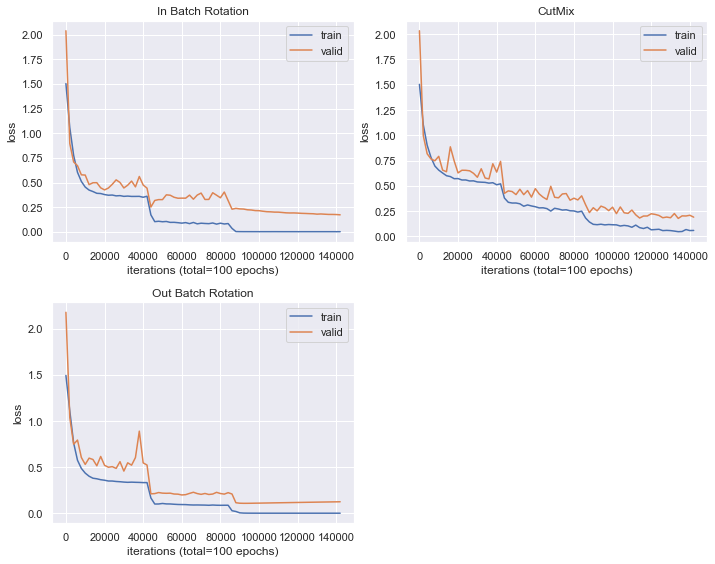

In [19]:
axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, len(train_results))
for i, (ax, train_file) in enumerate(zip(axs, train_results)):
    ax.plot(iterations, train_file['train_loss'][:total_records], label='train')
    ax.plot(iterations, train_file['valid_loss'][:total_records], label='valid')
    ax.set_ylabel('loss')
    ax.set_xlabel('iterations (total=100 epochs)')
    ax.legend(fancybox=True)
    ax.set_title(names[i])

fig = plt.gcf()
fig.tight_layout()
fig.savefig('./results/q1/loss_metrics.png', dpi=150)

<ipython-input-20-e2434c1d0c6e>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


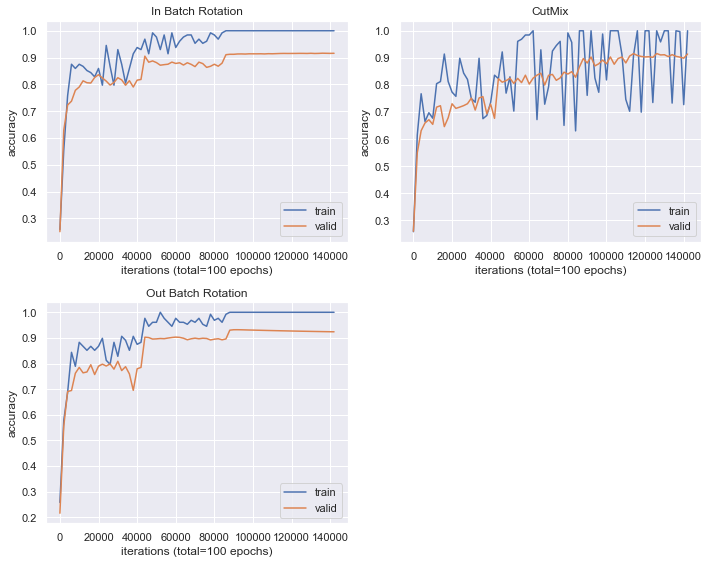

In [20]:
axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, len(train_results))
for i, (ax, train_file) in enumerate(zip(axs, train_results)):
    ax.plot(iterations, train_file['train_accuracy'][:total_records], label='train')
    ax.plot(iterations, train_file['valid_accuracy'][:total_records], label='valid')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('iterations (total=100 epochs)')
    ax.legend(fancybox=True)
    ax.set_title(names[i])

fig = plt.gcf()
fig.tight_layout()
fig.savefig('./results/q1/accuracy_metrics.png', dpi=150)

# Test Results on CIFAR10

In [21]:
for j in [1, 2, 3]:
    print('*'*20, f'cifar10 test results of part {j} ({names[j-1]})', '*'*20)
    print_test_result(
        [get_results(f'./results/q1/results_adl_pj3_q1.{j}_layer{i}_ts.pkl') for i in [1, 2, 3, 4]]
    )

******************** cifar10 test results of part 1 (In Batch Rotation) ********************
loss at stage 1 : 1.2049817947533945
accuracy at stage 1 : 0.5758785942492013
loss at stage 2 : 1.185086673821885
accuracy at stage 2 : 0.5969448881789138
loss at stage 3 : 1.514551522251897
accuracy at stage 3 : 0.5861621405750799
loss at stage 4 : 1.4317596728047624
accuracy at stage 4 : 0.47913338658146964
******************** cifar10 test results of part 2 (CutMix) ********************
loss at stage 1 : 1.1809755250973442
accuracy at stage 1 : 0.5907867412140575
loss at stage 2 : 1.130591779714956
accuracy at stage 2 : 0.6241493610223643
loss at stage 3 : 1.4814623750436802
accuracy at stage 3 : 0.5866637380191693
loss at stage 4 : 1.4672353765225639
accuracy at stage 4 : 0.4539057507987221
******************** cifar10 test results of part 3 (Out Batch Rotation) ********************
loss at stage 1 : 1.1878123907997205
accuracy at stage 1 : 0.5835662939297125
loss at stage 2 : 1.13166238705